# Lecture 5 Scribing
Ammar Raşid

300073700

In [1]:
using ArviZ
using CSV, DataFrames
using PyPlot
using Turing
using Random
using Distributions
using LinearAlgebra
using RecursiveArrayTools
using Pipe

ArviZ.use_style("arviz-darkgrid")
Turing.setprogress!(true)

import Logging
Logging.disable_logging(Logging.Warn)  # disabling long annoying warning
# P.S. logs were/better be enabled during development and debugging.

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/ammar/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
┌ Info: [Turing]: progress logging is enabled globally
└ @ Turing /home/ammar/.julia/packages/Turing/uAz5c/src/Turing.jl:30
┌ Info: [AdvancedVI]: global PROGRESS is set as true
└ @ AdvancedVI /home/ammar/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


LogLevel(1001)

# Problem Definition

Blood pressure is normally measured using cuff based methods. New contactless methods for blood pressure measurements rely on measuring time difference between two biomedical waveforms. This time difference is called pulse transit time or pulse arrival time (PAT). The relationship between systolic blood pressure and PAT is not clear but there are several potential options:
$$
BP = \alpha+\beta*\ln(PAT) + noise
$$

The goal is to find the coefficients $\alpha$ and $\beta$.

# Dataset

In [2]:
df = CSV.read("pat_sbp_nlin_3pt_new.csv", DataFrame, header=["SubjectNo", "PAT", "BP"])

4785×3 DataFrame
  Row │ SubjectNo  PAT      BP    
      │ Int64      Float64  Int64 
──────┼───────────────────────────
    1 │         1   0.3578    120
    2 │         1   0.3545    127
    3 │         1   0.364     109
    4 │         1   0.354     123
    5 │         1   0.351     121
    6 │         1   0.349     121
    7 │         1   0.3495    118
    8 │         1   0.3485    121
    9 │         1   0.351     120
   10 │         1   0.3485    117
   11 │         1   0.362     121
  ⋮   │     ⋮         ⋮       ⋮
 4776 │        10   0.35      114
 4777 │        10   0.351     114
 4778 │        10   0.355     114
 4779 │        10   0.3495    112
 4780 │        10   0.3505    114
 4781 │        10   0.354     115
 4782 │        10   0.3565    114
 4783 │        10   0.35      115
 4784 │        10   0.3555    116
 4785 │        10   0.365     116
                 4764 rows omitted

In [3]:
function get_xy(df)
    x = Float64.(df[!, :PAT])
    y = Float64.(df[!, :BP])
    s = Int64.(df[!, :SubjectNo])
    return Array(x), Array(y), s
end

function groupby_subject(df, dp_per_subject)
    @pipe df |>
    groupby(_, :SubjectNo) |>
    combine(_) do sdf
        if dp_per_subject>0
            idx = sample(1:size(sdf)[1], dp_per_subject, replace=false)
            data = sdf[idx, :]
        else
            data = sdf
        end
    end
end

function get_data(df;dp_per_subject)
    data = groupby_subject(df,dp_per_subject)
    return get_xy(data)
end

get_data (generic function with 1 method)

In [4]:
trainset = filter(row -> row.SubjectNo < 10, df)
testset = filter(row -> row.SubjectNo == 10, df);
J = length(unique(df[!, :SubjectNo])) # number of subjects
x_test, y_test, s_test = get_data(testset, dp_per_subject=-1);

# Hierarchical Model

Considering a dataset from $J$ subjects, each subject $j$ has $N_j$ data points.

<img src="h_model_all.png" width=400>

$$\begin{aligned}
\large{\mu_\alpha} &\large{\sim \mathcal{N}(0, 10)}&
\large{\lambda_\alpha} &\large{\sim Gamma(0.01, 0.01)}\\
\large{\mu_\beta} &\large{\sim \mathcal{N}(0, 10)}&
\large{\lambda_\beta} &\large{\sim Gamma(0.01, 0.01)}\\
\large{\lambda_\sigma} &\large{\sim Gamma(0.01, 0.01)}\\
\\
\large{\alpha_j} &\large{\sim \mathcal{N}(\mu_\alpha, 1/\sqrt{\lambda_\alpha})}&
\large{\beta_j} &\large{\sim \mathcal{N}(\mu_\beta, 1/\sqrt{\lambda_\beta})}\\
\large{\sigma_j} &\large{\sim \text{truncated}(\mathcal{N}(0, 1/\sqrt{\lambda_\sigma}), 0, \infty)}\\\\
% \large{\sigma} &\large{\sim \text{truncated}(\mathcal{N}(0, 10), 0, \infty)}\\\\
\large{y_{ij}} &\large{\sim \mathcal{N}(\alpha_j+x_{ij}\beta_j, \sigma)}
\end{aligned}$$

In [5]:
Turing.@model hierarchical_lr(x, y, s) = begin
#     J = length(unique(s)) # number of subjects
    
    # Priors
    μ_α ~ Normal(0, 10)
    λ_α ~ Gamma(0.01, 0.01)
    
    μ_β ~ Normal(0, 10)
    λ_β ~ Gamma(0.01, 0.01)
    
    λ_σ ~ Gamma(0.01, 0.01)
    
    # common subject distributions
#     α = Vector{Real}(undef, J)
#     β = Vector{Real}(undef, J)
#     σ = Vector{Real}(undef, J)
    
#     for j in 1:J
#         α[j] ~ Normal(μ_α, 1/sqrt(λ_α))
#         β[j] ~ Normal(μ_β, 1/sqrt(λ_β))
#         σ[j] ~ truncated(Normal(0, 1/sqrt(λ_σ)), 0, Inf)
#     end
    
    α ~ filldist(Normal(μ_α, 1/sqrt(λ_α)), J)
    β ~ filldist(Normal(μ_β, 1/sqrt(λ_β)), J)
    σ ~ filldist(truncated(Normal(0, 1/sqrt(λ_σ)), 0, Inf), J)
    for i in 1:length(x)
        j = s[i]
        μ = α[j] + log(x[i]) * β[j]    
        y[i] ~ Normal(μ, σ[j])
    end
end

hierarchical_lr (generic function with 1 method)

In [6]:
nwarmup, nsamples, nchains = 2000, 1000, 1;
sampler = NUTS(nwarmup, 0.65)
rng = Random.MersenneTwister(16653) # setting random seed for reproduceability

MersenneTwister(16653)

## Fitting on 3 data points per subject

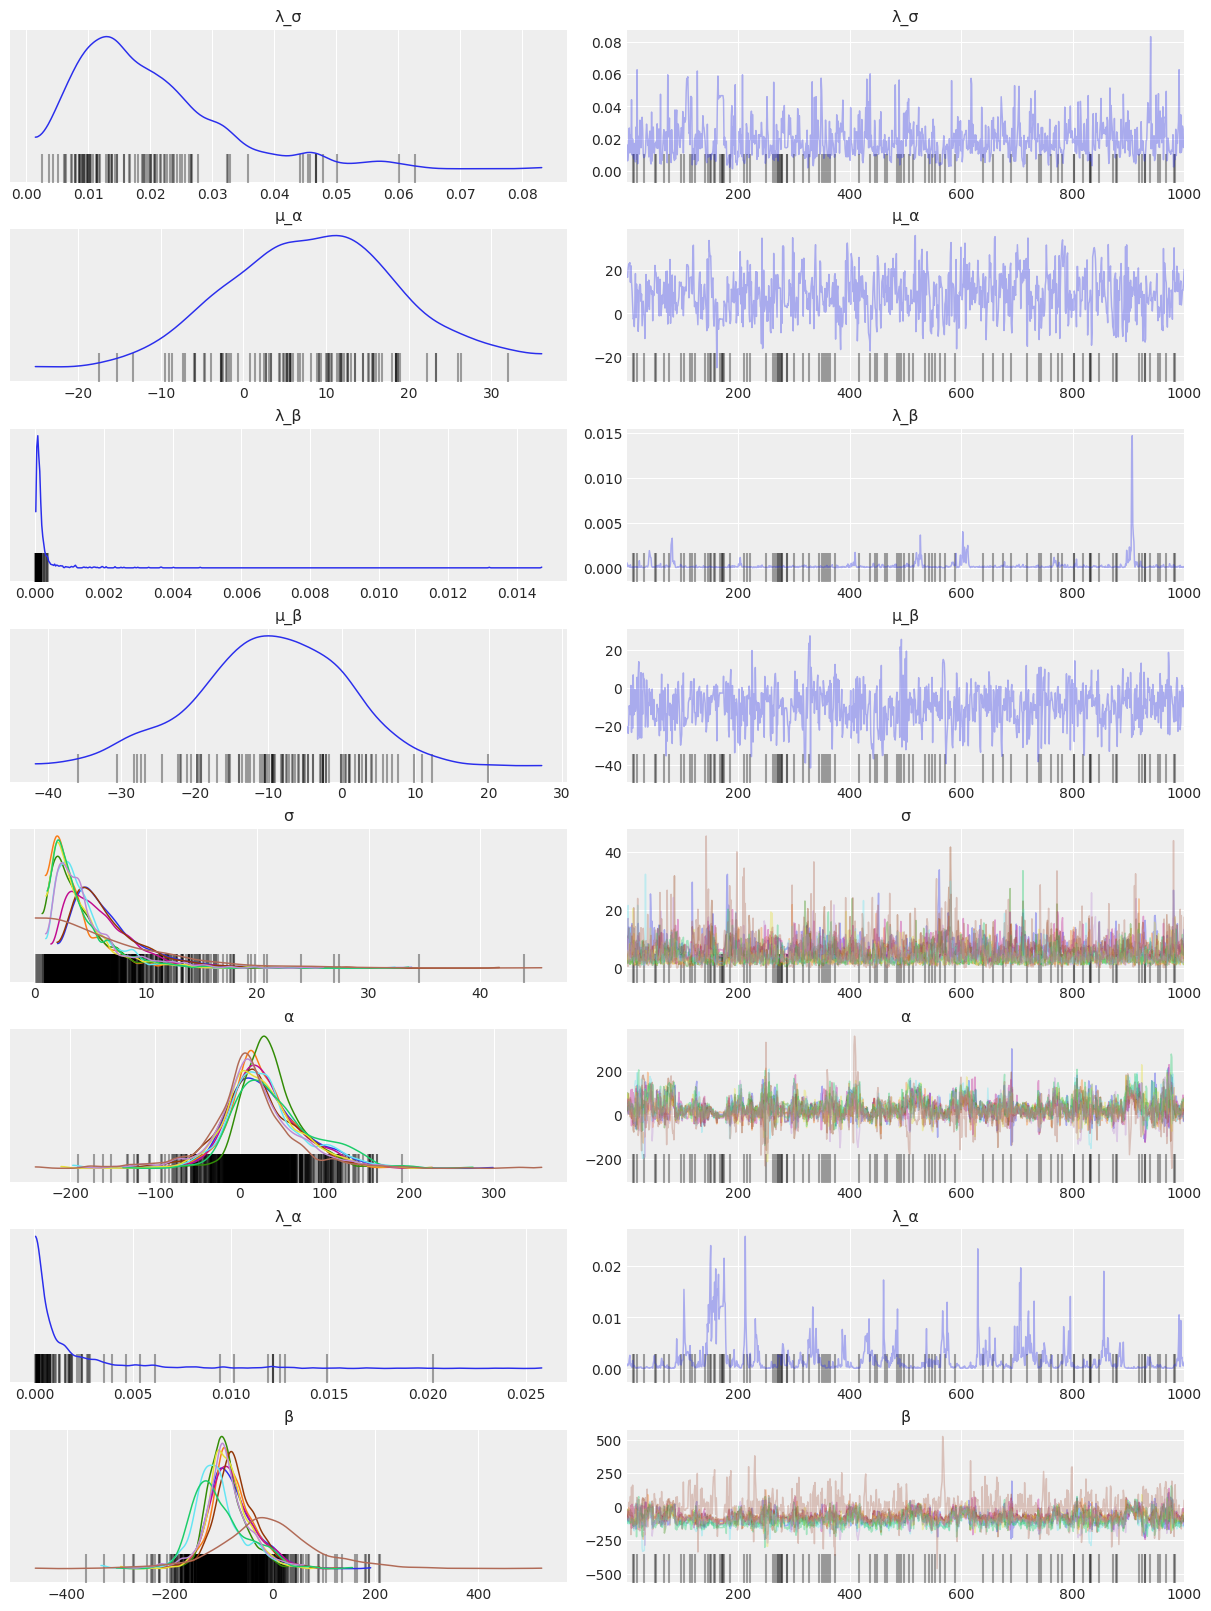

In [7]:
x3, y3, s3 = get_data(trainset, dp_per_subject=3)
h_model3 = hierarchical_lr(x3, y3, s3) # instantiate the model
h_chains3 = sample(
    rng, h_model3, sampler, nsamples; progress=true
)
plot_trace(h_chains3);

In [8]:
function evaluate_prediction(model, x, y, s, chains, title; plot_mean=false)
    predictor = model(x, similar(y, Missing), s)
    posterior_pred = predict(predictor, chains)
    a,b = plot_trace(posterior_pred)
    a.set_title(title)
    b.set_title(title)
    PyPlot.figure()
    pred_mean = reshape(mean(posterior_pred.value, dims=(1,3)), length(y));
    pred_std = reshape(std(posterior_pred.value, dims=(1,3)), length(y));
    mae_val = mean(abs.(pred_mean-y));
    
    idata = from_mcmcchains(
        chains;
        posterior_predictive=posterior_pred,
        observed_data=Dict("y" => y),
        constant_data=Dict("x"=>x),
        library="Turing",
        );
    
    plot_hdi(idata.constant_data.x, idata.posterior_predictive.y, fill_kwargs=Dict("label"=>"HDI"))
    PyPlot.scatter(x, y, c=s, label="data", alpha=0.5, s=7)
    if plot_mean
        n = 50
        xrng = LinRange(minimum(x), maximum(x), n)
        pp = predict(model(xrng, similar(1:n, Missing), Int32.(ones(n).*s[1])), chains)
        y_line = reshape(mean(pp.value, dims=(1,3)), n);
        PyPlot.plot(xrng, y_line, label=L"$\hat{y}$")
    end
    PyPlot.xlabel("PAT")
    PyPlot.ylabel("BP")
    PyPlot.title(title)
    PyPlot.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    return posterior_pred, mae_val
end

evaluate_prediction (generic function with 1 method)

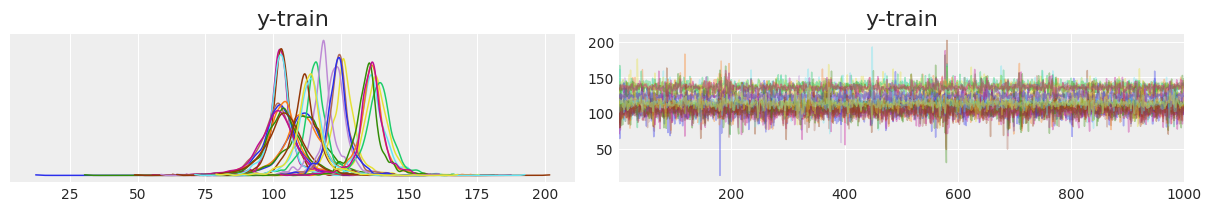

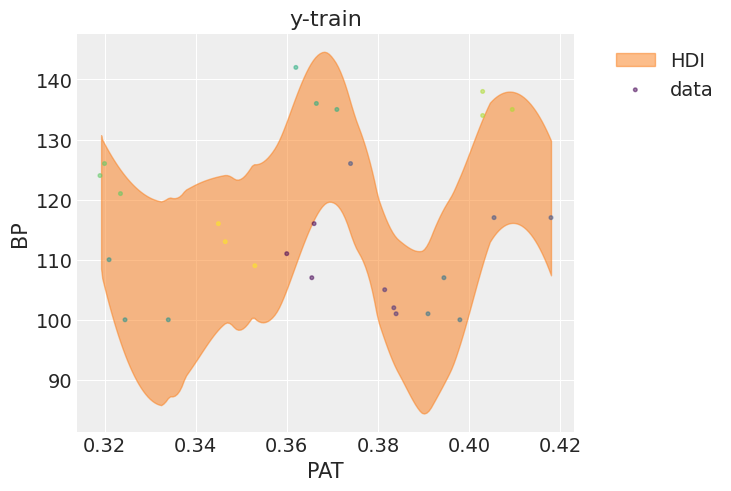

In [9]:
# predictions of the training set
posterior_pred, train_mae = evaluate_prediction(hierarchical_lr, x3, y3, s3, h_chains3, "y-train");

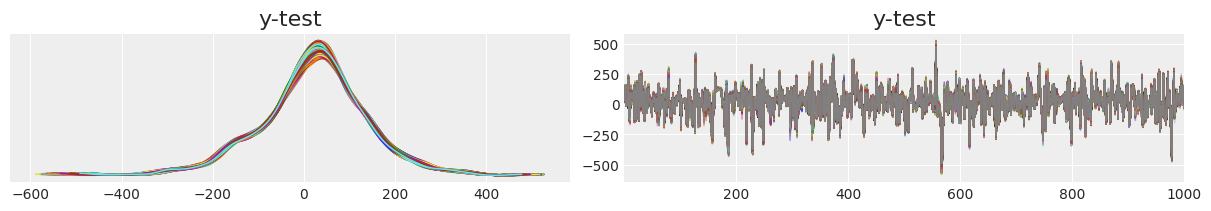

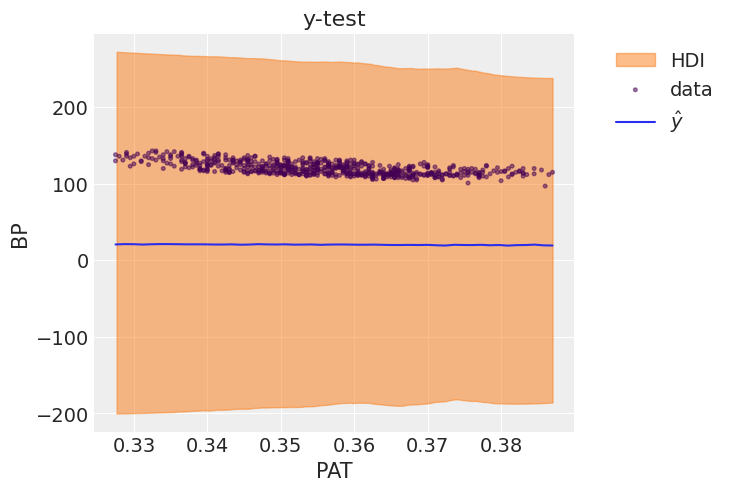

In [10]:
# predictions of the testing set
posterior_pred_test, test_mae = evaluate_prediction(hierarchical_lr, x_test, y_test, s_test, h_chains3, "y-test"; plot_mean=true);

In [11]:
println("Train MAE: $(train_mae)\nTest MAE: $(test_mae)")

Train MAE: 2.1156552420802566
Test MAE: 99.72055913020934


We see the model was successfully able to learn different posteriors for different subjects. Although the model was able to learn different parameters for different subjects, they are not clearly separated, especially $\sigma$ due to the lack of data points per subject.

In [12]:
# calculate pointwise loglikelihoods
loglikelihoods = Turing.pointwise_loglikelihoods(
        h_model3, MCMCChains.get_sections(h_chains3, :parameters)
)

# Ensure the ordering of the loglikelihoods matches the ordering of `posterior_predictive`
ynames = string.(keys(posterior_pred))
loglikelihoods_vals = getindex.(Ref(loglikelihoods), ynames)
# Reshape into `(nchains, nsamples, size(y)...)`
# Not using RecursiveArrayTools for the following operation is very likely to cause a StackOverflow error
loglikelihoods_arr = permutedims(convert(Array,VectorOfArray(loglikelihoods_vals)), (2,1,3));

In [13]:
idata_h3 = from_mcmcchains(
    h_chains3;
    posterior_predictive=posterior_pred,
    log_likelihood=Dict("y" => loglikelihoods_arr),
    observed_data=Dict("y" => y3),
    constant_data=Dict("x"=>x3),
    library="Turing",
    );

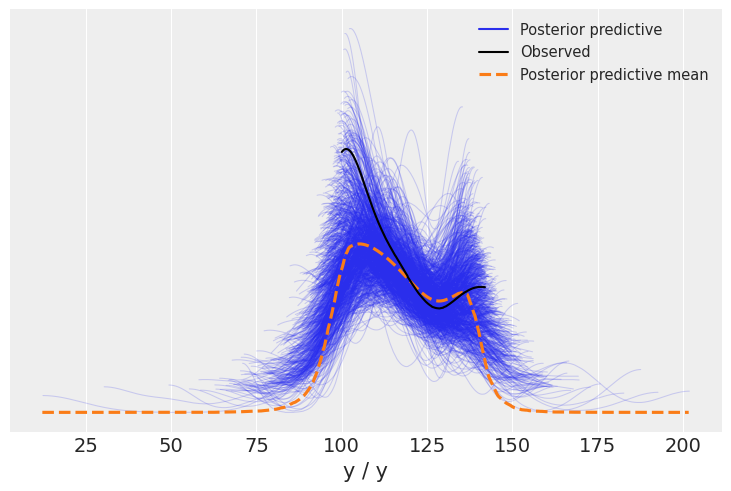

In [14]:
plot_ppc(idata_h3);

In [15]:
waic_h3 = waic(idata_h3)

/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


1×7 DataFrame
 Row │ waic      waic_se  p_waic   n_samples  n_data_points  warning  waic_sca ⋯
     │ Float64   Float64  Float64  Int64      Int64          Bool     String   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -80.9224  1.82643  11.4843       1000             27     true  log      ⋯
                                                                1 column omitted

In [16]:
loo_h3 = loo(idata_h3)

/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


1×7 DataFrame
 Row │ loo       loo_se   p_loo    n_samples  n_data_points  warning  loo_scal ⋯
     │ Float64   Float64  Float64  Int64      Int64          Bool     String   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -81.6403   1.9712  12.2021       1000             27     true  log      ⋯
                                                                1 column omitted

WAIC and LOO by themselves are not interpretable. We will have to compare them with other models' WAICs and LOOs.

### Refactoring the analysis into one function

In [17]:
function bayesian_lr(turing_mod, dp_per_subject)
    x, y, s = get_data(trainset, dp_per_subject=dp_per_subject)
    model = turing_mod(x, y, s) # instantiate the model
#     chains = sample(
#         rng, model, sampler, MCMCThreads(), nsamples, nchains; progress=false
#     )
    chains = sample(
        rng, model, sampler, nsamples; progress=false
    )
    plot_trace(chains);
    
    # predictions of the training set
    posterior_pred, train_mae = evaluate_prediction(turing_mod, x,y,s, chains, "y-train");
    # predictions of the testing set
    posterior_pred_test, test_mae = evaluate_prediction(turing_mod, x_test, y_test, s_test, chains, "y-test"; plot_mean=true);
    
    println("Train MAE: $(train_mae)\nTest MAE: $(test_mae)")
    
    loglikelihoods = Turing.pointwise_loglikelihoods(
            model, MCMCChains.get_sections(chains, :parameters)
    )

    ynames = string.(keys(posterior_pred))
    loglikelihoods_vals = getindex.(Ref(loglikelihoods), ynames)
    loglikelihoods_arr = permutedims(convert(Array,VectorOfArray(loglikelihoods_vals)), (2,1,3));
    
    idata = from_mcmcchains(
    chains;
    posterior_predictive=posterior_pred,
    log_likelihood=Dict("y" => loglikelihoods_arr),
    observed_data=Dict("y" => y),
    constant_data=Dict("x"=>x),
    library="Turing",
    );
    plot_ppc(idata)
    
    waic_val = waic(idata)
    loo_val = loo(idata)
    return idata, waic_val, loo_val
end

bayesian_lr (generic function with 1 method)

## Fitting on 10 data points per subject

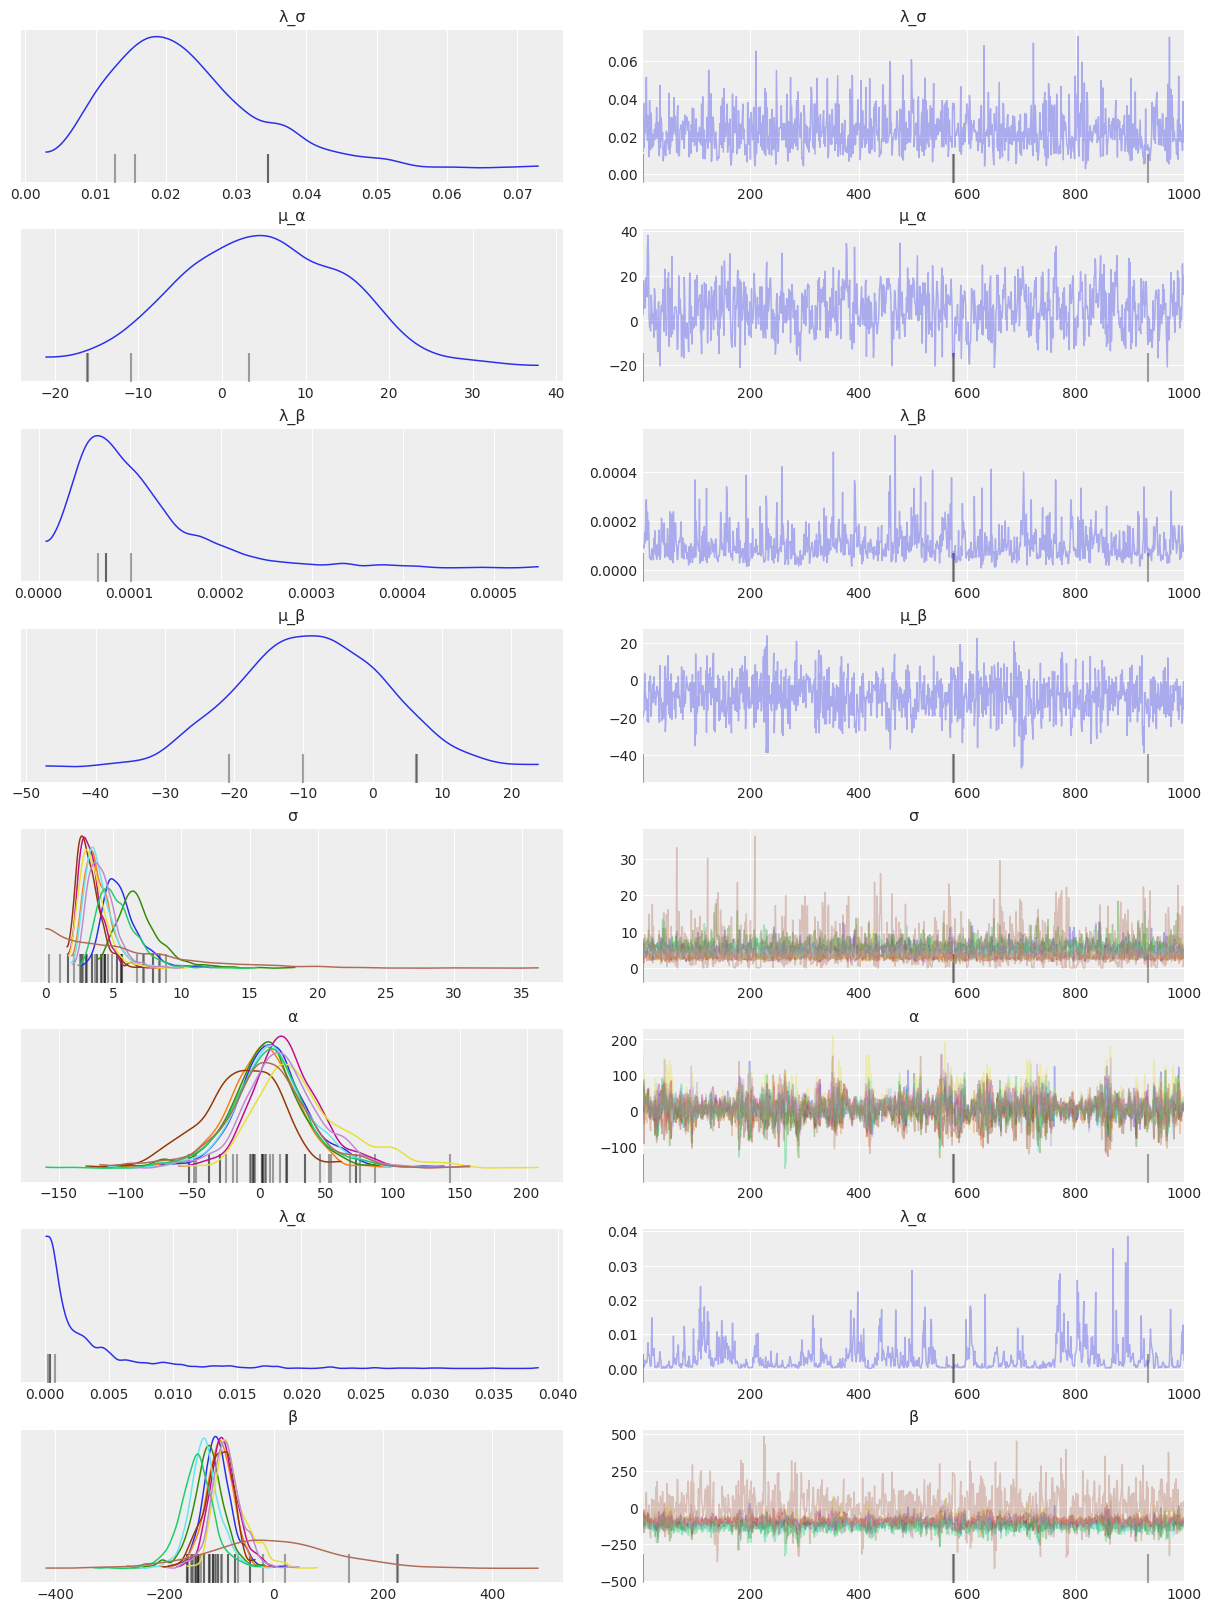

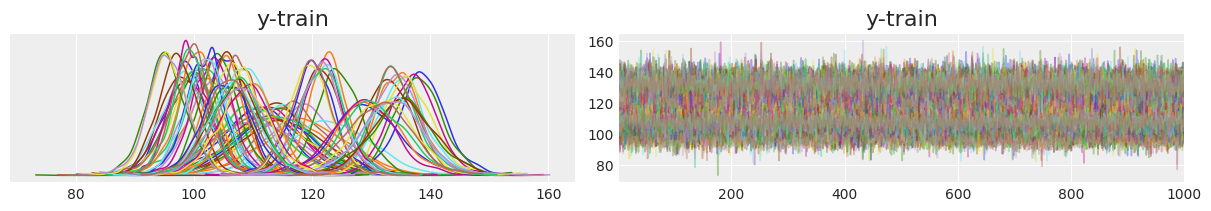

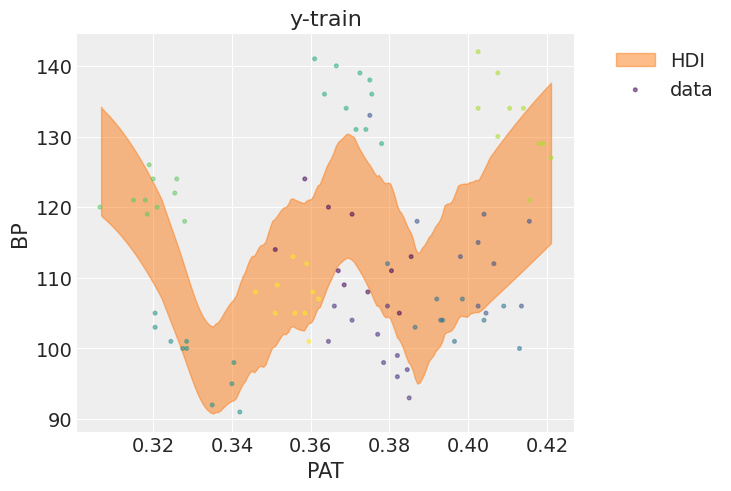

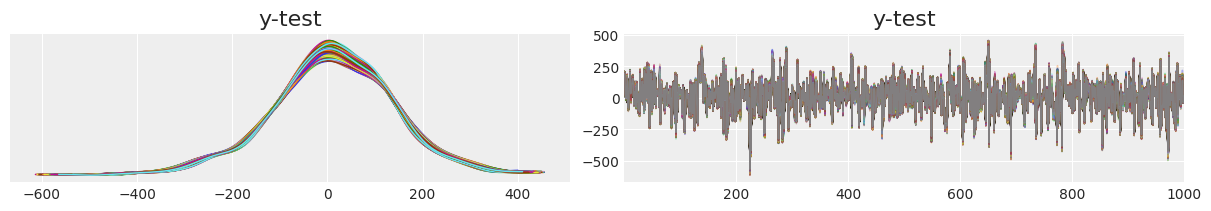

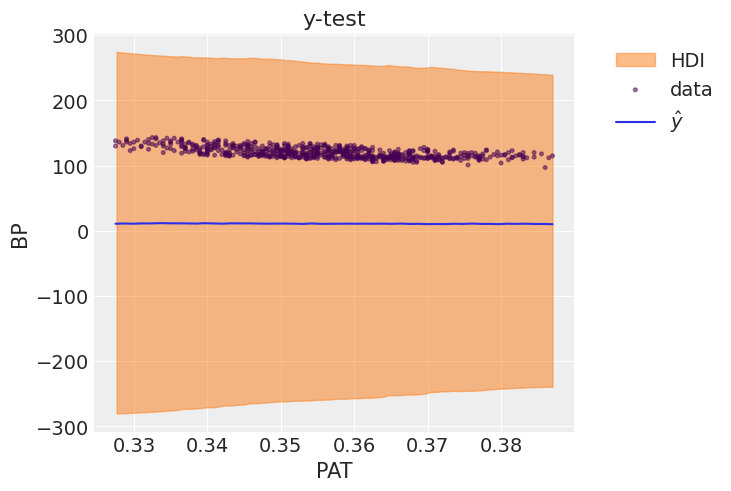

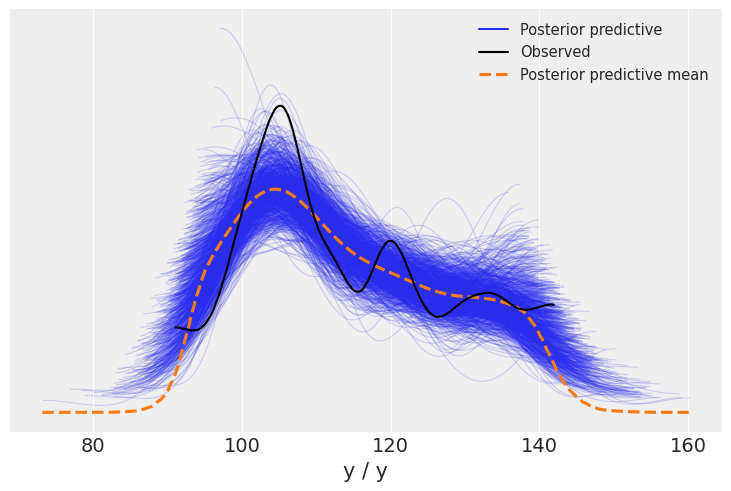

Train MAE: 3.14432624631192
Test MAE: 109.26197890513193


/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [18]:
idata_h10, waic_h10, loo_h10 = bayesian_lr(hierarchical_lr, 10);

With more data points the chains of the parameters show a relatively more clear distinction between different subjects. The uncertainty is still quite large around the predictive posterior.

## Fitting on all data points

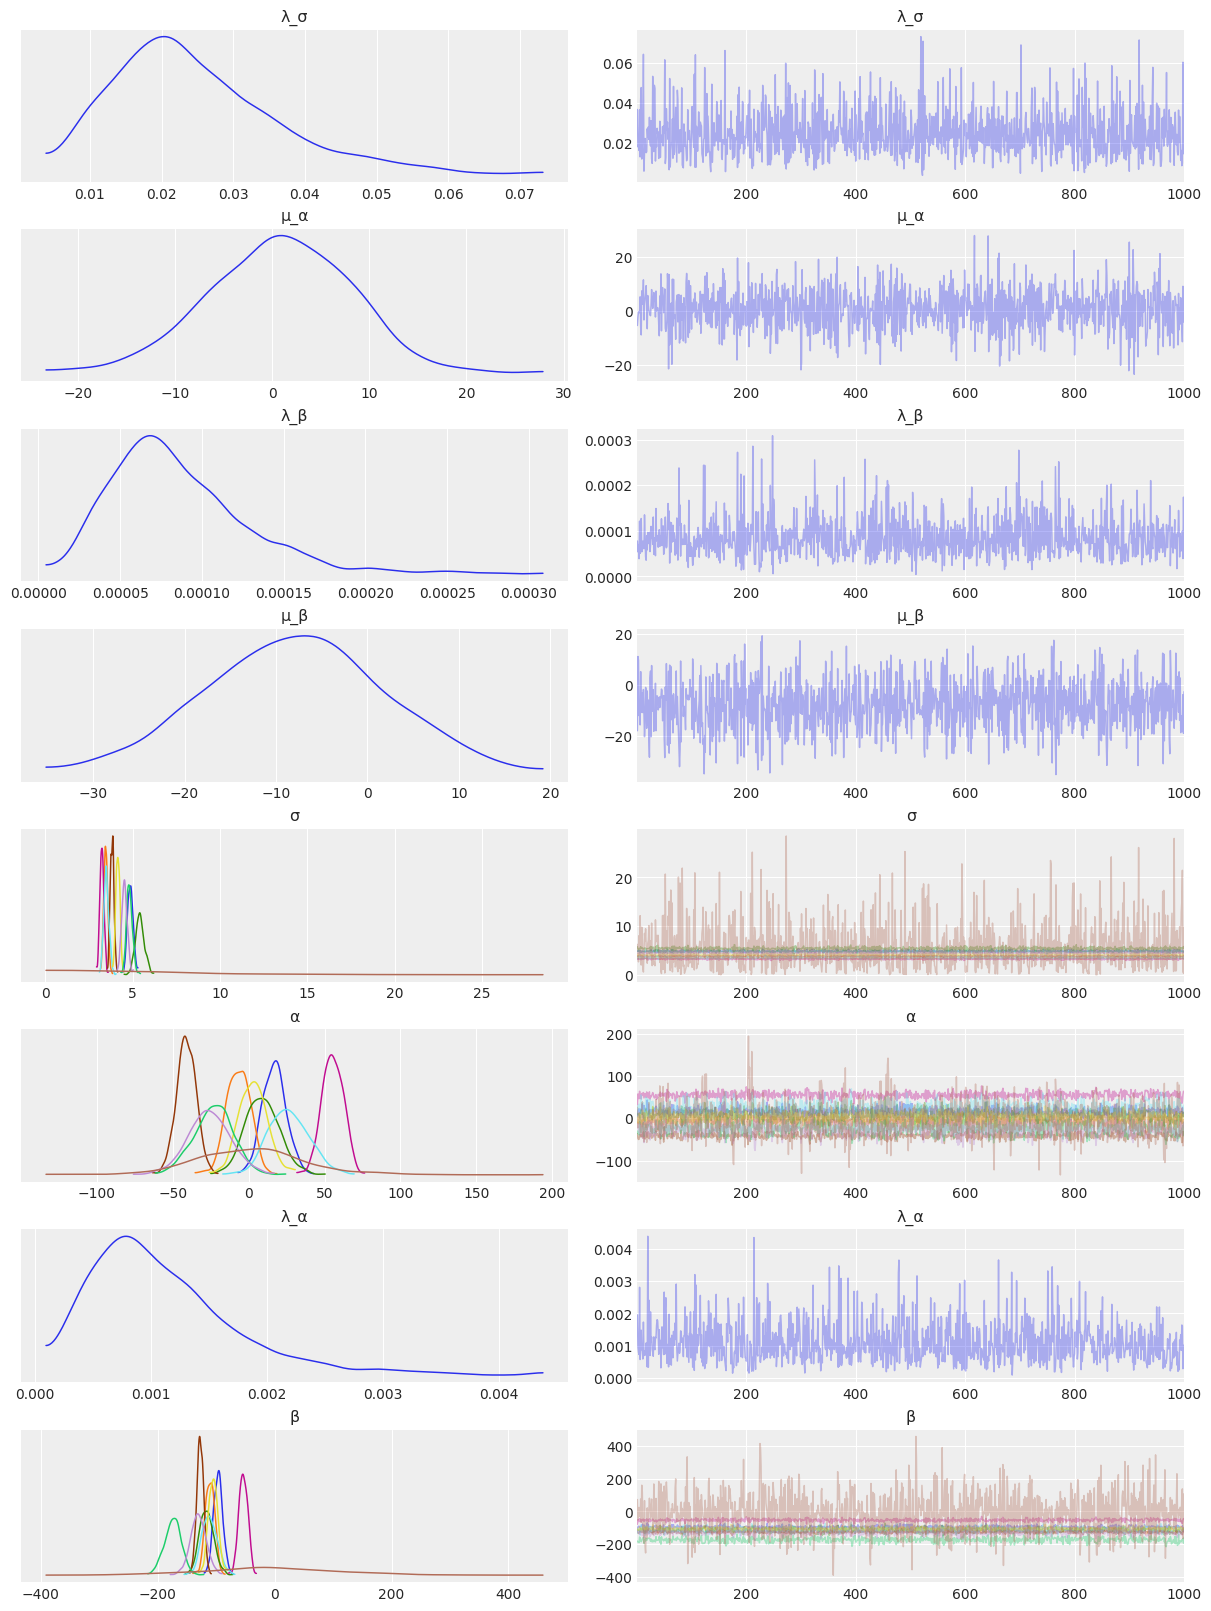

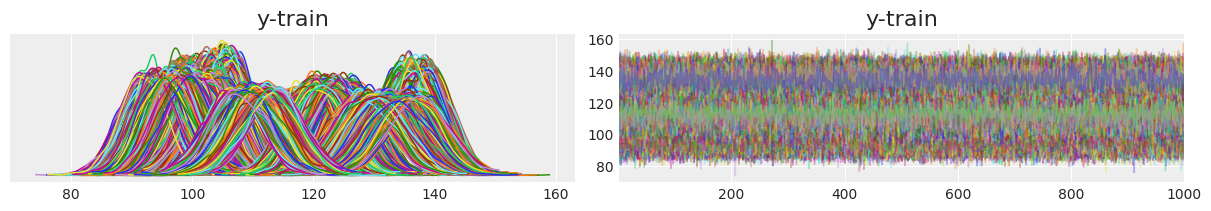

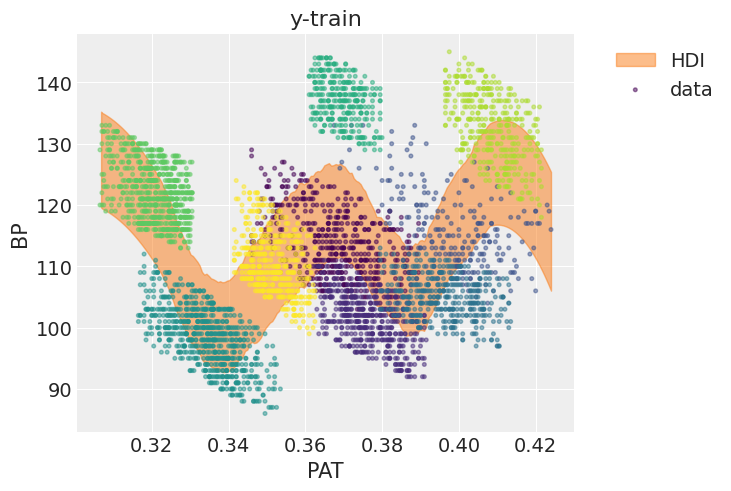

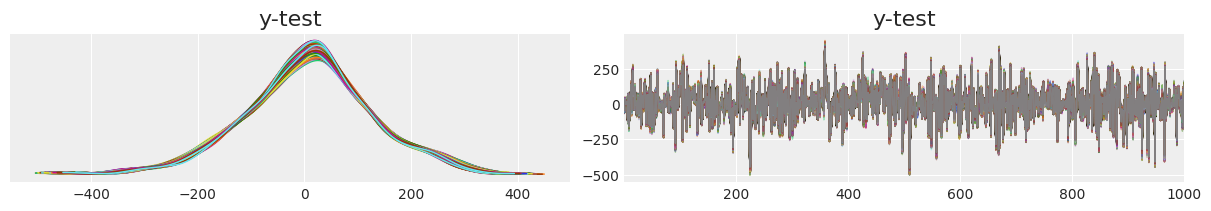

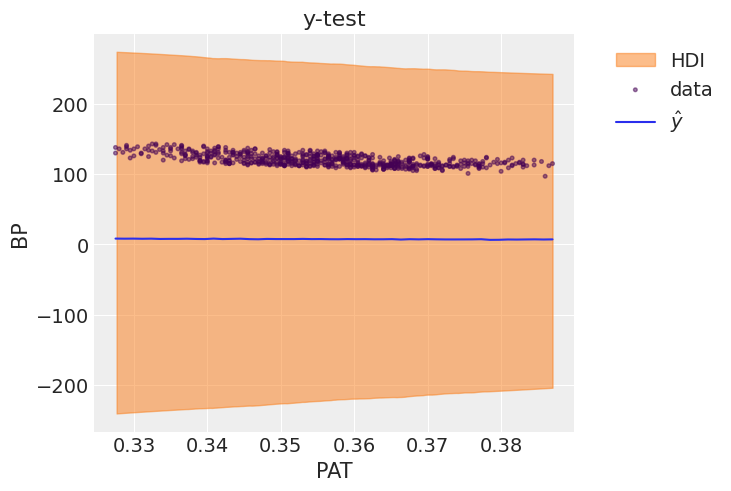

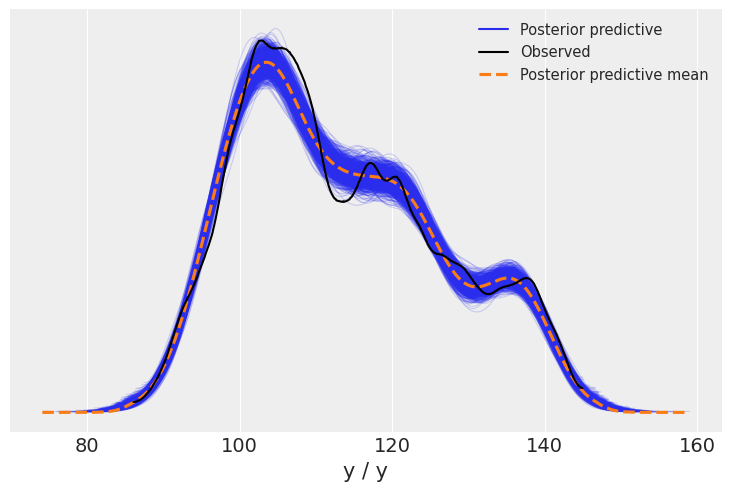

Train MAE: 3.4668484464622127
Test MAE: 112.6333742856784


In [19]:
idata_h, waic_h, loo_h = bayesian_lr(hierarchical_lr, -1);

We notice a much narrower confidence interval around the predictive posterior, indicating lower uncertainty. Parameters of different subjects are clearly distinguished.

# Pooled Model
We can combine all data points in a single pool of size $N$ with only one shared distribution over the coefficients.

<img src="p_model.png" width=400>

$$\begin{aligned}
\large{\alpha} &\large{\sim \mathcal{N}(0, 10)}\\
\large{\beta} &\large{\sim \mathcal{N}(0, 10)}\\
\large{\sigma} &\large{\sim \text{truncated}(\mathcal{N}(0, 10), 0, \infty)}\\\\
\large{y_{ij}} &\large{\sim \mathcal{N}(\alpha+x_{ij}\beta, \sigma)}
\end{aligned}$$

In [20]:
Turing.@model pooling_lr(x, y, s) = begin
    # priors
    α ~ Normal(0, 10)
    β ~ Normal(0, 10)
    σ ~ truncated(Normal(0, 10), 0, Inf)
    
    for i in 1:length(y)
        y[i] ~ Normal(α + x[i] * β, σ)
    end
end

pooling_lr (generic function with 1 method)

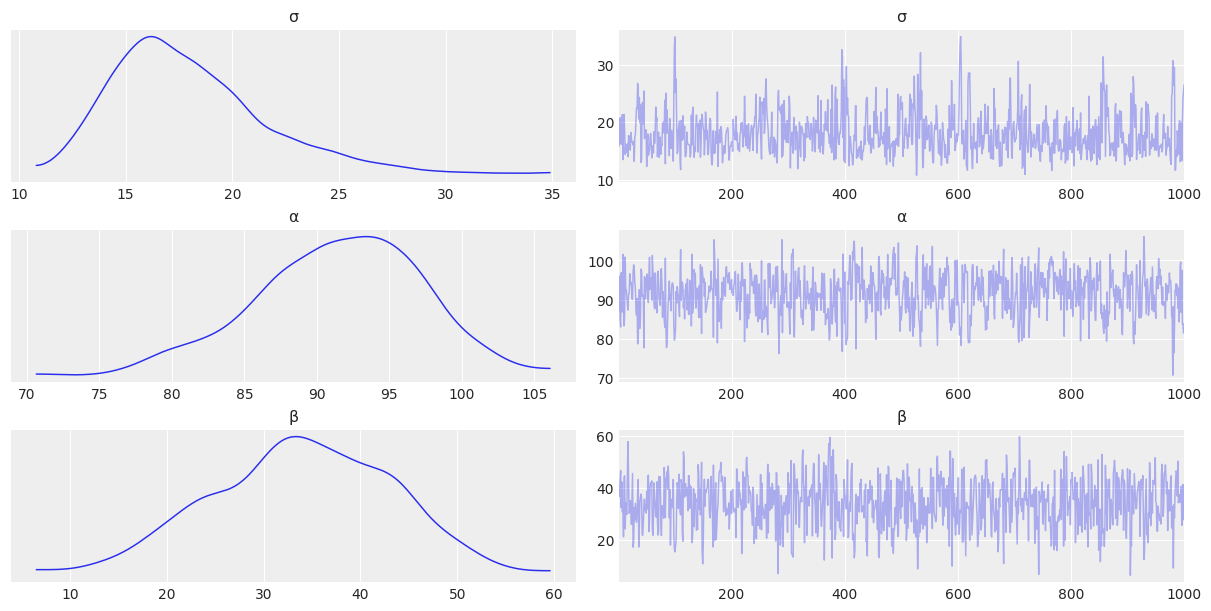

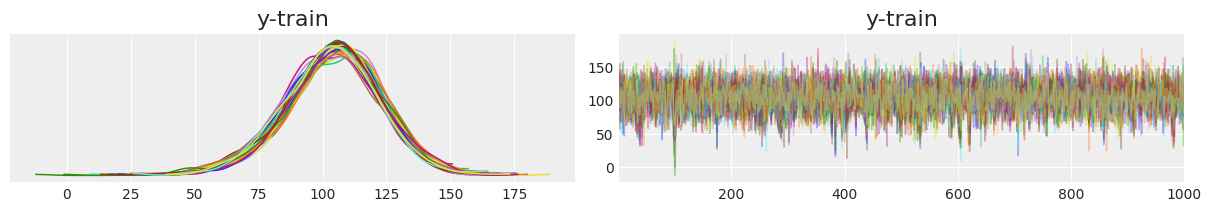

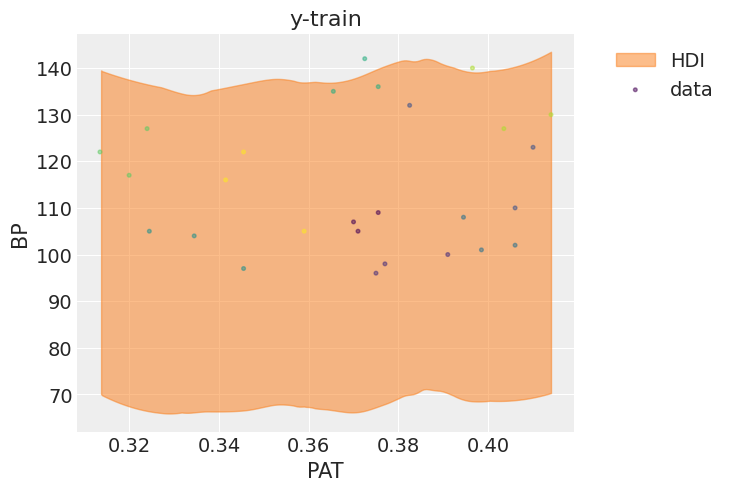

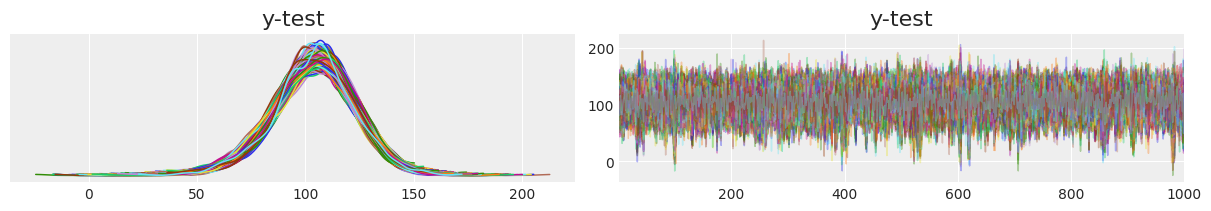

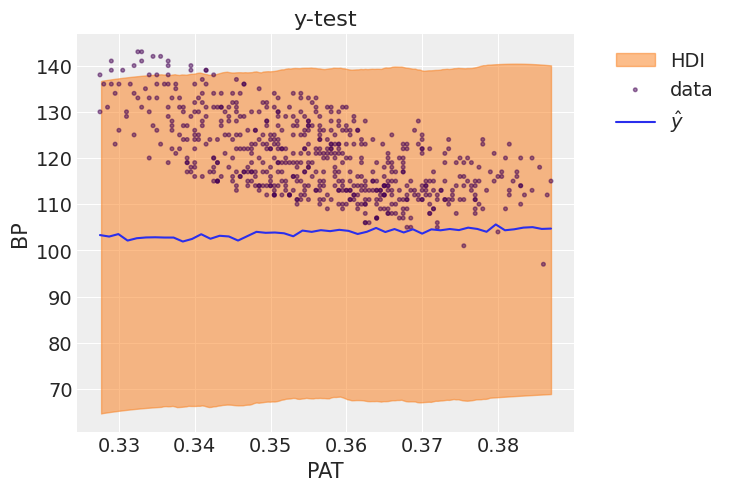

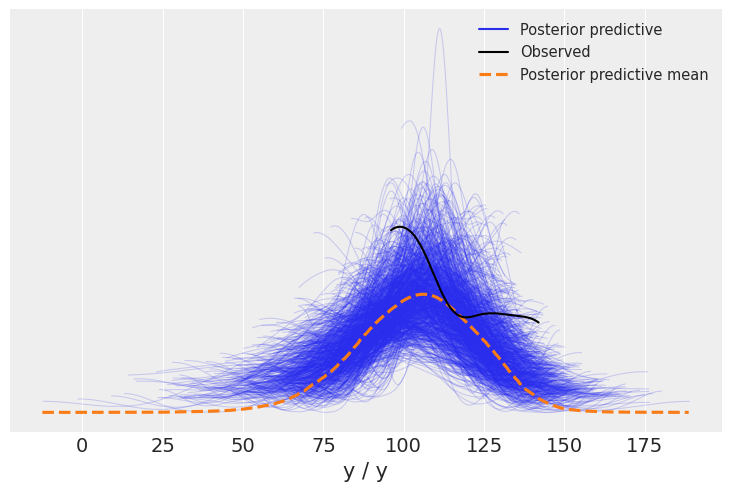

Train MAE: 13.628362430185236
Test MAE: 16.609554884127917


In [21]:
idata_p3, waic_p3, loo_p3 = bayesian_lr(pooling_lr, 3);

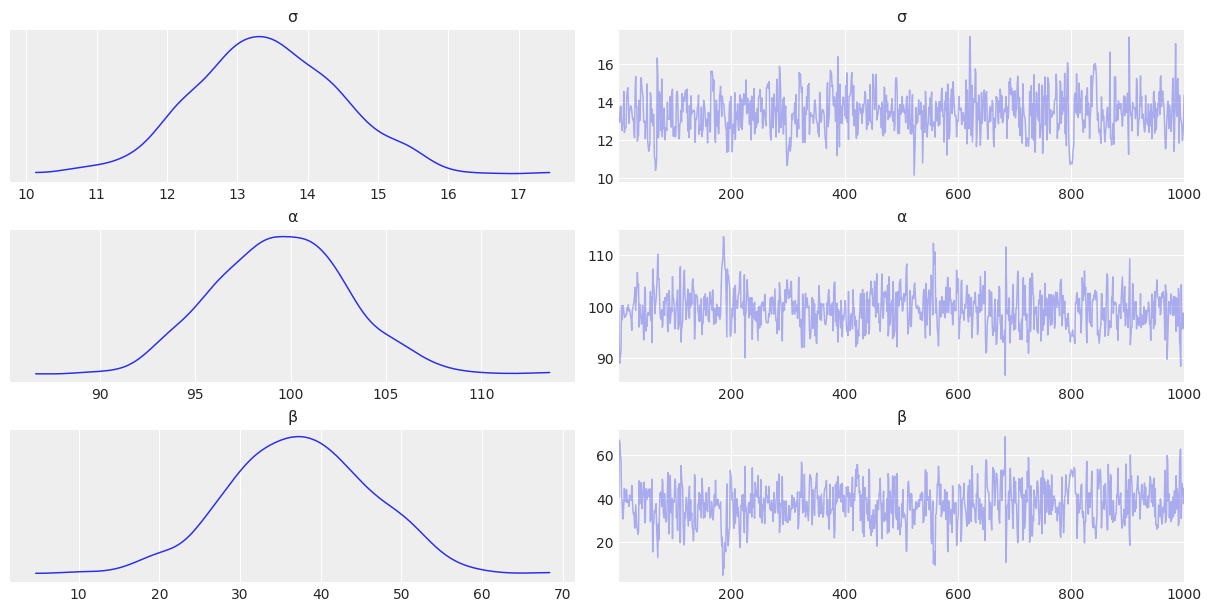

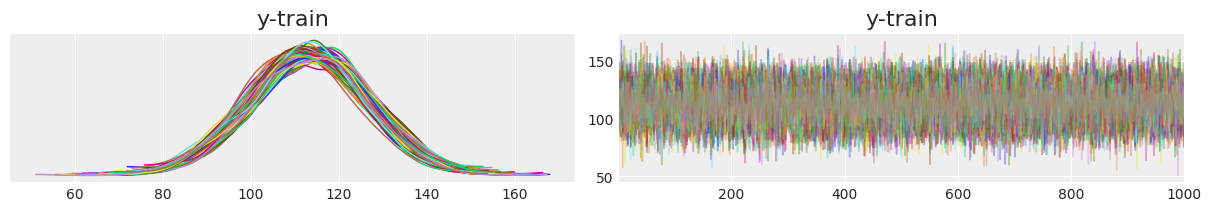

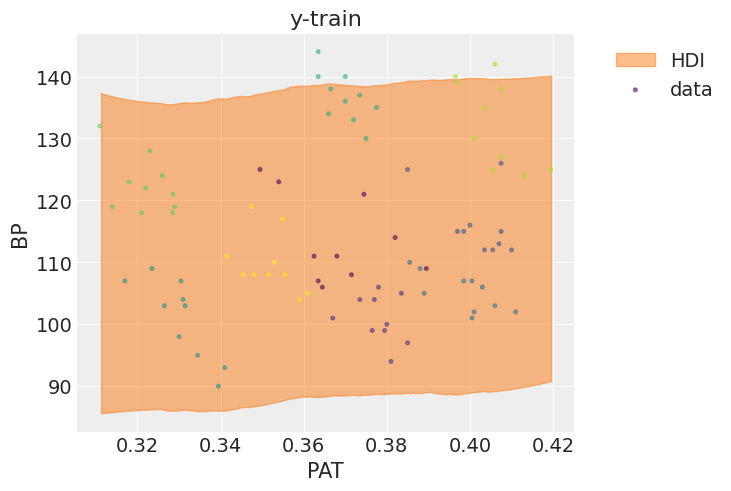

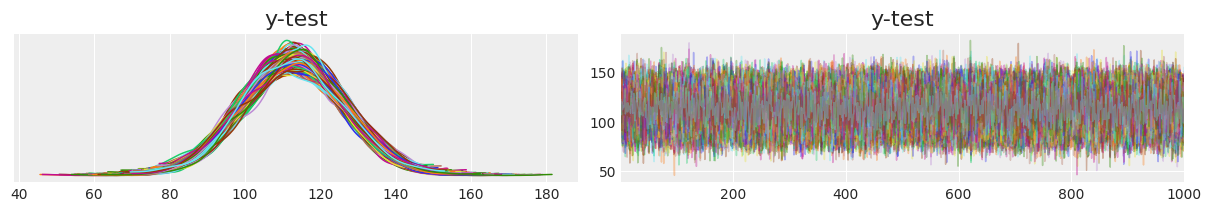

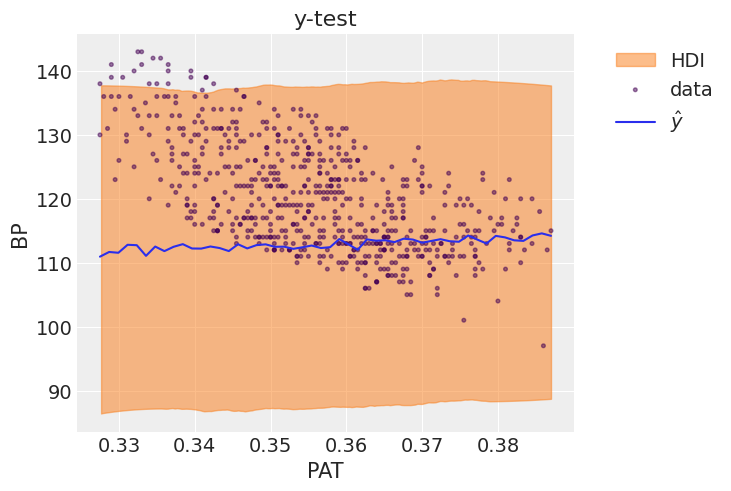

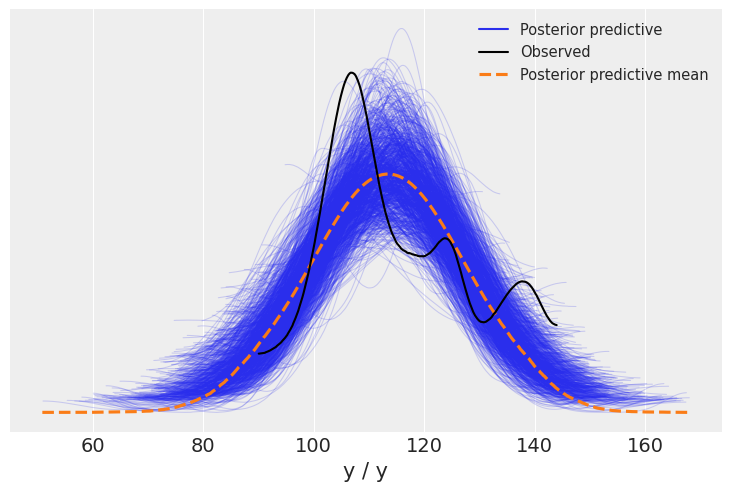

Train MAE: 11.03969329876136
Test MAE: 8.654889551677318


In [22]:
idata_p10, waic_p10, loo_p10 = bayesian_lr(pooling_lr, 10);

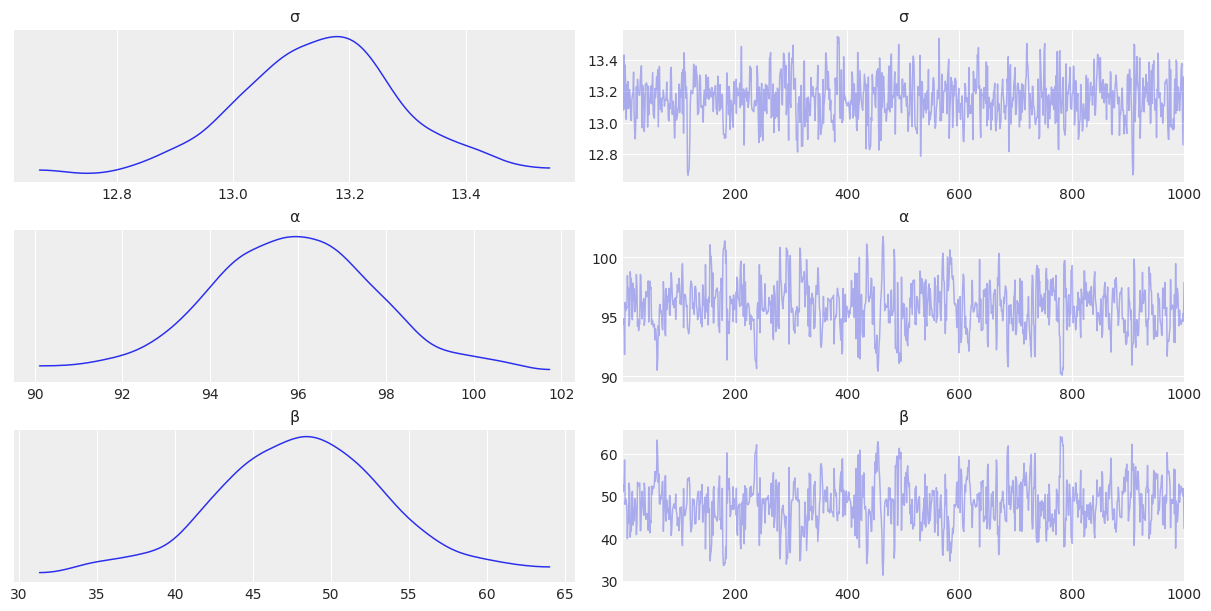

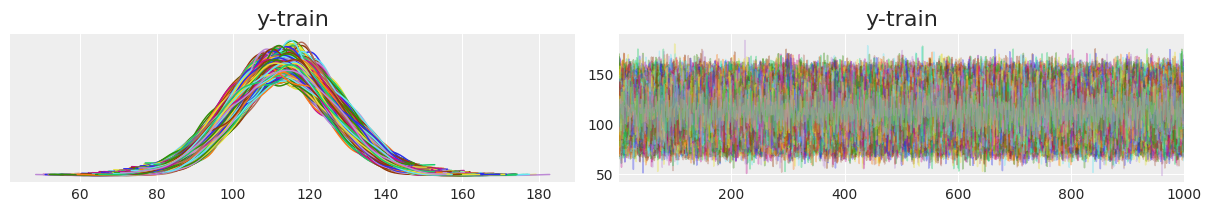

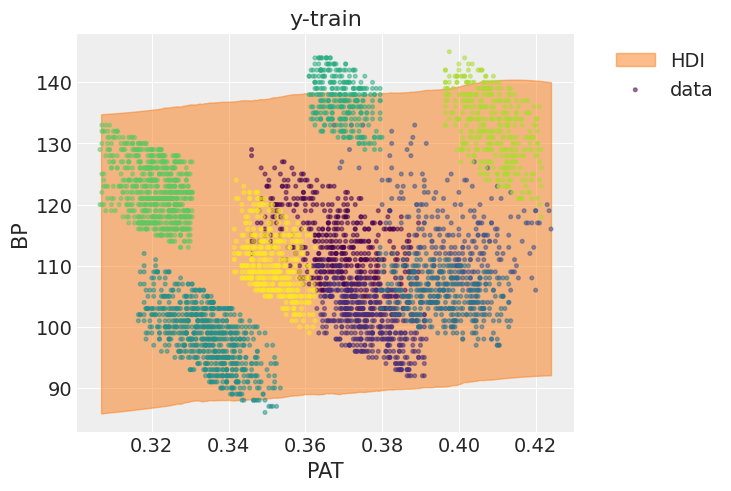

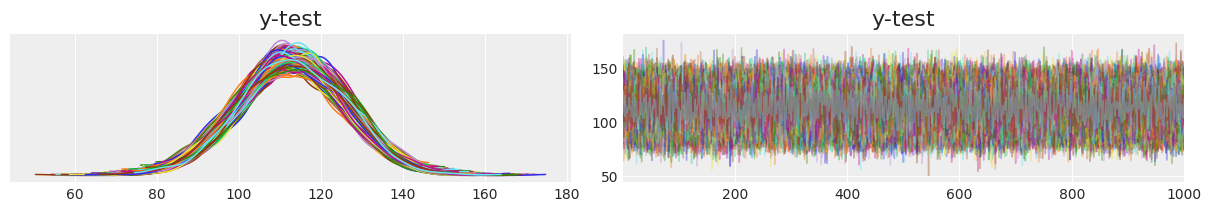

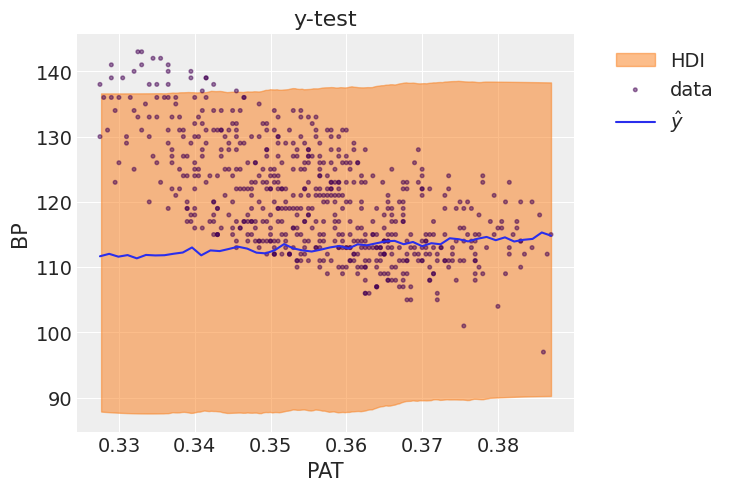

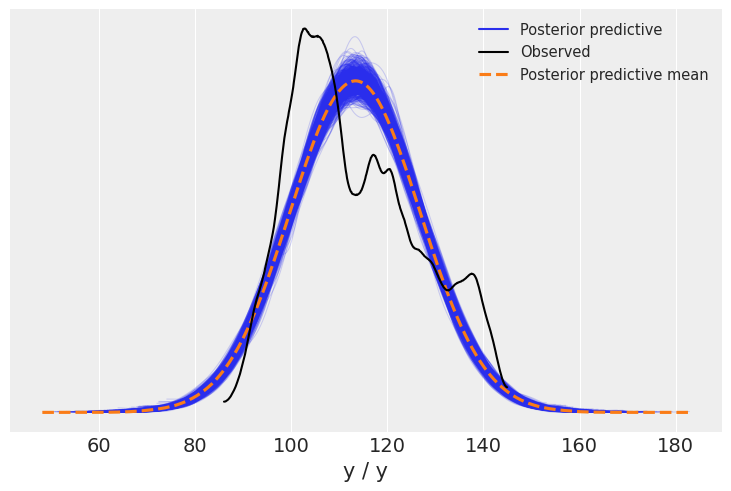

Train MAE: 11.261234943699856
Test MAE: 8.615367765984198


In [23]:
idata_p, waic_p, loo_p = bayesian_lr(pooling_lr, -1);

## WAIC & LOO

In [25]:
function compare_waic_loo(p_idata, h_idata)
    display(compare(Dict(
        "pooled" => p_idata,
        "hierarchical" => h_idata,
        ), ic="waic", scale="deviance"))
    
    display(compare(Dict(
        "pooled" => p_idata,
        "hierarchical" => h_idata,
        ), ic="loo", scale="deviance"))
end

compare_waic_loo (generic function with 1 method)

In [26]:
compare_waic_loo(idata_p3, idata_h3);

2×10 DataFrame
 Row │ name          rank   waic     p_waic    d_waic   weight   se       dse  ⋯
     │ String        Int64  Float64  Float64   Float64  Float64  Float64  Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ hierarchical      0  161.845  11.4843    0.0         1.0  3.65287  0.0  ⋯
   2 │ pooled            1  236.064   1.87427  74.2191      0.0  6.95102  8.87
                                                               3 columns omitted

2×10 DataFrame
 Row │ name          rank   loo      p_loo     d_loo    weight   se       dse  ⋯
     │ String        Int64  Float64  Float64   Float64  Float64  Float64  Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ hierarchical      0  163.281  12.2021    0.0         1.0  3.9424    0.0 ⋯
   2 │ pooled            1  236.082   1.88327  72.8014      0.0  6.95798   9.0
                                                               3 columns omitted

/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is depreca

In [27]:
compare_waic_loo(idata_p10, idata_h10);

2×10 DataFrame
 Row │ name          rank   waic     p_waic    d_waic   weight   se       dse  ⋯
     │ String        Int64  Float64  Float64   Float64  Float64  Float64  Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ hierarchical      0  523.191  14.5973     0.0        1.0  11.1366   0.0 ⋯
   2 │ pooled            1  725.65    1.76825  202.458      0.0  11.5674  15.9
                                                               3 columns omitted

2×10 DataFrame
 Row │ name          rank   loo      p_loo     d_loo    weight   se       dse  ⋯
     │ String        Int64  Float64  Float64   Float64  Float64  Float64  Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ hierarchical      0  524.972  15.4876     0.0        1.0  11.5832   0.0 ⋯
   2 │ pooled            1  725.659   1.77282  200.687      0.0  11.5699  16.2
                                                               3 columns omitted

/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is depreca

In [28]:
compare_waic_loo(idata_p, idata_h);

2×10 DataFrame
 Row │ name          rank   waic     p_waic    d_waic   weight       se        ⋯
     │ String        Int64  Float64  Float64   Float64  Float64      Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ hierarchical      0  23564.9  22.3369      0.0   1.0          69.5209   ⋯
   2 │ pooled            1  33320.2   2.13193  9755.32  6.25722e-13  68.5305
                                                               3 columns omitted

2×10 DataFrame
 Row │ name          rank   loo      p_loo     d_loo    weight       se        ⋯
     │ String        Int64  Float64  Float64   Float64  Float64      Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ hierarchical      0  23564.9  22.3397      0.0   1.0          69.5211   ⋯
   2 │ pooled            1  33320.2   2.13197  9755.32  2.06946e-13  68.5305
                                                               3 columns omitted

/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/ammar/myenv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated

# References
[1] <a href="https://revbayes.github.io/tutorials/intro/graph_models.html#bayesian-linear-regression"> Will Freyman "<i> Introduction to Graphical Models</i>"</a>

[2] <a href="https://num.pyro.ai/en/0.6.0/tutorials/bayesian_hierarchical_linear_regression.html"> Carlos Souza "<i>Bayesian Hierarchical Linear Regression</i></a>

[3] <a href="https://arviz-devs.github.io/ArviZ.jl/dev/quickstart/"> ArviZ.jl Quickstart </a>